# In this notebook I will present my models which used for predictions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = pd.read_csv('../creditcard.csv')

In [3]:
X = df.iloc[:, :-1]
y = df['Class']

In [4]:
und = RandomUnderSampler()
X_und, y_und = und.fit_resample(X, y)

In [5]:
Counter(y_und)

Counter({0: 492, 1: 492})

In [6]:
# Lets concat undersampled X and y
df_und = pd.concat([X_und, y_und], axis=1)
df_und.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,43472.0,-2.703379,-2.765187,1.634296,-0.921596,2.548505,-3.138880,-1.394357,0.030538,-1.443436,...,-0.143472,-0.962849,0.347564,0.374059,0.456712,0.924996,-0.174454,0.102622,13.94,0
1,133456.0,2.128006,-1.815790,-0.232000,-1.739638,-1.561162,0.581367,-1.903957,0.244592,-0.915388,...,-0.043637,0.246593,0.268189,0.200817,-0.532771,-0.256869,0.052548,-0.027736,64.30,0
2,61869.0,-0.805320,-0.979016,2.281645,-1.474275,-0.873525,0.729081,-0.033706,0.185215,0.171499,...,0.287699,0.896826,-0.069809,-0.419164,0.306186,-0.117887,-0.093309,-0.124221,145.59,0
3,12443.0,1.105762,-0.616627,0.816607,0.339242,-0.900344,0.138514,-0.719458,0.063580,2.698915,...,-0.399295,-0.884769,-0.075285,-0.466664,0.157056,0.950496,-0.084727,0.012128,94.85,0
4,49506.0,-1.305315,-0.801638,2.517726,-0.561589,-1.311136,0.589640,0.660796,-0.744293,0.225922,...,-0.110095,0.694828,0.140696,0.437557,-0.223559,-0.281383,-0.974422,-0.238621,160.00,0


## Lets build our first Pipeline

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier

In [15]:
algos = {
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB' : GaussianNB(),
    'LogisticRegression' : LogisticRegression(max_iter=200),
#     'BaggingClassifier' : BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
}

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_und, y_und)

In [17]:
for name, classifier in algos.items():
    pipeline = Pipeline(steps=[
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)
    y_predicted=pipeline.predict_proba(X_test)
    print(name,'ROC SCORE', roc_auc_score(y_test, y_predicted[:, 1]))

DecisionTreeClassifier ROC SCORE 0.8937520661157025
KNeighborsClassifier ROC SCORE 0.668198347107438
GaussianNB ROC SCORE 0.9586776859504131
LogisticRegression ROC SCORE 0.969785123966942


### As we can see Gaussian Naive Bayes along side with Logistic regression performed well on the data
### Now I will try ensemble methods

In [18]:
ensem = {
    'RandomForestClassifier' : RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LGBMClassifier' : LGBMClassifier(),
    'CatBoostClassifier' : CatBoostClassifier(verbose=False),
}

In [19]:
for name, classifier in ensem.items():
    pipe_en = Pipeline(steps=[
        ('classifier', classifier)
    ])
    pipe_en.fit(X_train, y_train)
    y_predicted=pipe_en.predict_proba(X_test)
    print(name,'ROC SCORE', roc_auc_score(y_test, y_predicted[:, 1]))

RandomForestClassifier ROC SCORE 0.9723305785123966
GradientBoostingClassifier ROC SCORE 0.9738181818181818
LGBMClassifier ROC SCORE 0.979702479338843
CatBoostClassifier ROC SCORE 0.9795702479338844


## The accuracy might change depending on train test split so we will try cross validation 

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [22]:
models = {
    'LogisticRegression' : LogisticRegression(max_iter=200 ),
    'RandomForestClassifier' : RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LGBMClassifier' : LGBMClassifier(),
    'CatBoostClassifier' : CatBoostClassifier(verbose=False),
    'BaggingClassifier': BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
}

In [23]:
results = []
names = []

for name, model in models.items():
    skfold = StratifiedKFold(n_splits=10)
    cv_results = cross_val_score(model, X_und, y_und, cv=skfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LogisticRegression: 0.960918 (0.040008)
RandomForestClassifier: 0.970503 (0.029596)
GradientBoostingClassifier: 0.962829 (0.031238)
LGBMClassifier: 0.968870 (0.029562)
CatBoostClassifier: 0.973272 (0.027171)
BaggingClassifier: 0.968474 (0.031461)


In [25]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## In the EDA notebook we saw that dimensionality reduction techniques were useful. Let's try predicting on them

In [17]:
X_new = df_und[['V12', 'V14', 'V10', 'V11', 'V17']]
y_new = df_und.iloc[:, -1]

In [18]:
results = []
names = []

for name, model in models.items():
    skfold = StratifiedKFold(n_splits=10)
    pipeline = Pipeline(steps=[
        ('dim_red', PCA()),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    cv_results = cross_val_score(pipeline, X_new, y_new, cv=skfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

GaussianNB: 0.959539 (0.032323)


C:\Users\egadi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: 0.955950 (0.026540)
RandomForestClassifier: 0.957468 (0.035475)
GradientBoostingClassifier: 0.948928 (0.036886)
LGBMClassifier: 0.952370 (0.031205)
CatBoostClassifier: 0.955455 (0.028704)


In [19]:
results = []
names = []

for name, model in models.items():
    skfold = StratifiedKFold(n_splits=10)
    pipeline = Pipeline(steps=[
        ('dim_red', PCA()),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    cv_results = cross_val_score(pipeline, X_new, y_new, cv=skfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

GaussianNB: 0.959539 (0.032323)


C:\Users\egadi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: 0.955950 (0.026540)
RandomForestClassifier: 0.958044 (0.034374)
GradientBoostingClassifier: 0.949633 (0.037050)
LGBMClassifier: 0.952370 (0.031205)
CatBoostClassifier: 0.955455 (0.028704)


In [44]:
import optuna
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm
import lightgbm as lgb

In [40]:
# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
#     iris = sklearn.datasets.load_iris()
#     x, y = iris.data, iris.target

    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = sklearn.svm.SVC(C=svc_c, gamma="auto")
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=10
        )

    score = sklearn.model_selection.cross_val_score(classifier_obj, X_und, y_und, n_jobs=-1, cv=3, scoring='roc_auc')
    accuracy = score.mean()
    return accuracy


In [41]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-04-23 10:08:43,666] A new study created in memory with name: no-name-0d0e27a1-0220-41a2-bffe-f45f2d306f30
[I 2021-04-23 10:08:43,758] Trial 0 finished with value: 0.9564867142573865 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3}. Best is trial 0 with value: 0.9564867142573865.
[I 2021-04-23 10:08:43,945] Trial 1 finished with value: 0.4949248958953005 and parameters: {'classifier': 'SVC', 'svc_c': 95136932.98816553}. Best is trial 0 with value: 0.9564867142573865.
[I 2021-04-23 10:08:44,016] Trial 2 finished with value: 0.9557555026769781 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 10}. Best is trial 0 with value: 0.9564867142573865.
[I 2021-04-23 10:08:44,100] Trial 3 finished with value: 0.9486230914138409 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 29}. Best is trial 0 with value: 0.9564867142573865.
[I 2021-04-23 10:08:44,176] Trial 4 finished with value: 0.9526075748562363 and parameters: {'classifier': 'RandomForest

[I 2021-04-23 10:08:47,724] Trial 40 finished with value: 0.955142028554432 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 12}. Best is trial 15 with value: 0.9635385683125124.
[I 2021-04-23 10:08:47,811] Trial 41 finished with value: 0.9460514574657942 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 4}. Best is trial 15 with value: 0.9635385683125124.
[I 2021-04-23 10:08:47,900] Trial 42 finished with value: 0.9496641384096769 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 5}. Best is trial 15 with value: 0.9635385683125124.
[I 2021-04-23 10:08:47,992] Trial 43 finished with value: 0.9597337894110648 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3}. Best is trial 15 with value: 0.9635385683125124.
[I 2021-04-23 10:08:48,079] Trial 44 finished with value: 0.9490258774538964 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2}. Best is trial 15 with value: 0.9635385683125124.
[I 2021-04-23 10:08:48,167] Trial 4

[I 2021-04-23 10:08:51,402] Trial 80 finished with value: 0.9437400852667063 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2}. Best is trial 15 with value: 0.9635385683125124.
[I 2021-04-23 10:08:51,476] Trial 81 finished with value: 0.9548941602220901 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3}. Best is trial 15 with value: 0.9635385683125124.
[I 2021-04-23 10:08:51,560] Trial 82 finished with value: 0.9613697204045213 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3}. Best is trial 15 with value: 0.9635385683125124.
[I 2021-04-23 10:08:51,641] Trial 83 finished with value: 0.9564061570493753 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 4}. Best is trial 15 with value: 0.9635385683125124.
[I 2021-04-23 10:08:51,700] Trial 84 finished with value: 0.9607314594487409 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2}. Best is trial 15 with value: 0.9635385683125124.
[I 2021-04-23 10:08:51,765] Trial 8

FrozenTrial(number=15, values=[0.9635385683125124], datetime_start=datetime.datetime(2021, 4, 23, 10, 8, 45, 250842), datetime_complete=datetime.datetime(2021, 4, 23, 10, 8, 45, 356441), params={'classifier': 'RandomForest', 'rf_max_depth': 6}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'RandomForest')), 'rf_max_depth': IntLogUniformDistribution(high=32, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=15, state=TrialState.COMPLETE, value=None)


In [42]:
def objective(trial):
    data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return accuracy

In [45]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-23 10:10:00,768] A new study created in memory with name: no-name-4e9edc0e-399f-41de-b49c-4ffe18cc6d25
[I 2021-04-23 10:10:00,844] Trial 0 finished with value: 0.9735105957616952 and parameters: {'lambda_l1': 1.7116940813146702e-07, 'lambda_l2': 3.6166856136736264e-07, 'num_leaves': 158, 'feature_fraction': 0.7281119227011377, 'bagging_fraction': 0.598008723364909, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 0 with value: 0.9735105957616952.
[I 2021-04-23 10:10:00,983] Trial 1 finished with value: 0.9505494505494506 and parameters: {'lambda_l1': 0.00017781395291338654, 'lambda_l2': 3.8300030923728006, 'num_leaves': 210, 'feature_fraction': 0.8343161842873656, 'bagging_fraction': 0.7541852861689529, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 0 with value: 0.9735105957616952.
[I 2021-04-23 10:10:01,057] Trial 2 finished with value: 0.967467159277504 and parameters: {'lambda_l1': 0.005019713703390371, 'lambda_l2': 1.573843213705107e-07, 'num_leaves

[I 2021-04-23 10:10:03,397] Trial 22 finished with value: 0.9711460855528652 and parameters: {'lambda_l1': 1.3091750382830323e-08, 'lambda_l2': 0.19140963951942008, 'num_leaves': 227, 'feature_fraction': 0.8761735983635903, 'bagging_fraction': 0.6230312823981393, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 3 with value: 0.9787234042553192.
[I 2021-04-23 10:10:03,521] Trial 23 finished with value: 0.9738868081564711 and parameters: {'lambda_l1': 0.004912732867094552, 'lambda_l2': 0.005530802269483108, 'num_leaves': 250, 'feature_fraction': 0.6503445538144471, 'bagging_fraction': 0.5168089948693002, 'bagging_freq': 1, 'min_child_samples': 67}. Best is trial 3 with value: 0.9787234042553192.
[I 2021-04-23 10:10:03,674] Trial 24 finished with value: 0.9426535087719299 and parameters: {'lambda_l1': 0.010811787946789254, 'lambda_l2': 0.004812265017124495, 'num_leaves': 256, 'feature_fraction': 0.6554346901426585, 'bagging_fraction': 0.4607785136611256, 'bagging_freq': 1, 'min_

[I 2021-04-23 10:10:07,116] Trial 45 finished with value: 0.9474304573314475 and parameters: {'lambda_l1': 3.798656629363934e-06, 'lambda_l2': 2.818378420433351e-08, 'num_leaves': 208, 'feature_fraction': 0.722337228612683, 'bagging_fraction': 0.6876596830104683, 'bagging_freq': 3, 'min_child_samples': 14}. Best is trial 38 with value: 0.9835164835164836.
[I 2021-04-23 10:10:07,285] Trial 46 finished with value: 0.9651937046004843 and parameters: {'lambda_l1': 0.0015245545656115199, 'lambda_l2': 9.773663466677798e-06, 'num_leaves': 54, 'feature_fraction': 0.628758647314315, 'bagging_fraction': 0.6123705960325917, 'bagging_freq': 4, 'min_child_samples': 35}. Best is trial 38 with value: 0.9835164835164836.
[I 2021-04-23 10:10:07,443] Trial 47 finished with value: 0.9522727272727273 and parameters: {'lambda_l1': 4.567012257160708, 'lambda_l2': 7.22830478467166e-08, 'num_leaves': 201, 'feature_fraction': 0.41853521702019236, 'bagging_fraction': 0.5822276576139348, 'bagging_freq': 2, 'min_

[I 2021-04-23 10:10:10,510] Trial 68 finished with value: 0.9745762711864407 and parameters: {'lambda_l1': 0.07714424700977006, 'lambda_l2': 3.330031762352414e-05, 'num_leaves': 255, 'feature_fraction': 0.7044556031089261, 'bagging_fraction': 0.703672535239444, 'bagging_freq': 1, 'min_child_samples': 42}. Best is trial 38 with value: 0.9835164835164836.
[I 2021-04-23 10:10:10,651] Trial 69 finished with value: 0.9763957307060755 and parameters: {'lambda_l1': 0.3189218931380555, 'lambda_l2': 9.383823207823226e-05, 'num_leaves': 230, 'feature_fraction': 0.4587553317467747, 'bagging_fraction': 0.8524523571153537, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 38 with value: 0.9835164835164836.
[I 2021-04-23 10:10:10,787] Trial 70 finished with value: 0.9640686061658706 and parameters: {'lambda_l1': 0.034143453667296854, 'lambda_l2': 0.0003173417974789226, 'num_leaves': 229, 'feature_fraction': 0.45721888314520487, 'bagging_fraction': 0.8746595457176976, 'bagging_freq': 1, 'min

[I 2021-04-23 10:10:14,108] Trial 91 finished with value: 0.9647727272727272 and parameters: {'lambda_l1': 0.12944162894349273, 'lambda_l2': 9.691695213224116e-05, 'num_leaves': 226, 'feature_fraction': 0.5195798338218693, 'bagging_fraction': 0.7142795393016189, 'bagging_freq': 1, 'min_child_samples': 41}. Best is trial 76 with value: 0.9945054945054945.
[I 2021-04-23 10:10:14,254] Trial 92 finished with value: 0.9455974842767296 and parameters: {'lambda_l1': 0.23739108397365452, 'lambda_l2': 7.265447762495767e-06, 'num_leaves': 251, 'feature_fraction': 0.5561315987613894, 'bagging_fraction': 0.8036124419782575, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 76 with value: 0.9945054945054945.
[I 2021-04-23 10:10:14,421] Trial 93 finished with value: 0.9455456095481671 and parameters: {'lambda_l1': 0.008496263264191494, 'lambda_l2': 0.0001407420860673578, 'num_leaves': 237, 'feature_fraction': 0.4712181546798422, 'bagging_fraction': 0.9298082170258634, 'bagging_freq': 1, 'mi

Number of finished trials: 100
Best trial:
  Value: 0.9945054945054945
  Params: 
    lambda_l1: 0.1267835490884181
    lambda_l2: 0.0001503296134650899
    num_leaves: 227
    feature_fraction: 0.40077411008938724
    bagging_fraction: 0.7449106646390713
    bagging_freq: 4
    min_child_samples: 38


## This the best result so far

In [46]:
import xgboost as xgb

import optuna


def objective(trial):
    (data, target) = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy

In [47]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-23 10:11:55,034] A new study created in memory with name: no-name-96fb65c0-acc5-4045-93d2-f0e7c98e62a7
[I 2021-04-23 10:11:55,078] Trial 0 finished with value: 0.8741258741258742 and parameters: {'booster': 'gblinear', 'lambda': 0.007567705356017098, 'alpha': 6.769157956501422e-06, 'subsample': 0.5395309145238563, 'colsample_bytree': 0.9398771259753687}. Best is trial 0 with value: 0.8741258741258742.
[I 2021-04-23 10:11:55,134] Trial 1 finished with value: 0.9370629370629371 and parameters: {'booster': 'dart', 'lambda': 0.6501735203262589, 'alpha': 3.504815266796234e-06, 'subsample': 0.542746201784825, 'colsample_bytree': 0.7252168501697736, 'max_depth': 9, 'min_child_weight': 8, 'eta': 9.06011891067165e-06, 'gamma': 0.021723417897566696, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.009407983314419702, 'skip_drop': 1.0362135573457234e-05}. Best is trial 1 with value: 0.9370629370629371.
[I 2021-04-23 10:11:55,193] Trial 2 

[I 2021-04-23 10:11:56,801] Trial 19 finished with value: 0.9230769230769231 and parameters: {'booster': 'gbtree', 'lambda': 9.599780230208407e-07, 'alpha': 9.387896339845384e-05, 'subsample': 0.8442302675293591, 'colsample_bytree': 0.38647387026728136, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.0010955699949461526, 'gamma': 2.5292494642852146e-08, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.972027972027972.
[I 2021-04-23 10:11:56,913] Trial 20 finished with value: 0.9230769230769231 and parameters: {'booster': 'gbtree', 'lambda': 3.100941437946913e-08, 'alpha': 0.8903863854483682, 'subsample': 0.639794326905953, 'colsample_bytree': 0.7998623272045722, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.6837871538338344, 'gamma': 0.00015631547609066407, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.972027972027972.
[I 2021-04-23 10:11:57,024] Trial 21 finished with value: 0.958041958041958 and parameters: {'booster': 'gbtree', 'lambda': 1.0083487718342217

[I 2021-04-23 10:11:59,091] Trial 38 finished with value: 0.9370629370629371 and parameters: {'booster': 'gbtree', 'lambda': 1.6638607986621608e-05, 'alpha': 4.067091209442716e-06, 'subsample': 0.5584909169208668, 'colsample_bytree': 0.6481211081836007, 'max_depth': 9, 'min_child_weight': 8, 'eta': 2.3581742925139013e-06, 'gamma': 0.03851033813681557, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.972027972027972.
[I 2021-04-23 10:11:59,179] Trial 39 finished with value: 0.8811188811188811 and parameters: {'booster': 'gblinear', 'lambda': 2.5726780758915003e-08, 'alpha': 0.008085040751495229, 'subsample': 0.8712832564211267, 'colsample_bytree': 0.8304824598818531}. Best is trial 16 with value: 0.972027972027972.
[I 2021-04-23 10:11:59,301] Trial 40 finished with value: 0.951048951048951 and parameters: {'booster': 'gbtree', 'lambda': 1.5878200413753212e-06, 'alpha': 1.623962619313308e-05, 'subsample': 0.5158733776844772, 'colsample_bytree': 0.7172426764484627, 'max_depth':

[I 2021-04-23 10:12:01,415] Trial 57 finished with value: 0.9370629370629371 and parameters: {'booster': 'gbtree', 'lambda': 9.102103286667672e-07, 'alpha': 6.935670465073088e-05, 'subsample': 0.8273770046474362, 'colsample_bytree': 0.7761039480709379, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.0007624458955711877, 'gamma': 0.1433114311733307, 'grow_policy': 'lossguide'}. Best is trial 52 with value: 0.9790209790209791.
[I 2021-04-23 10:12:01,543] Trial 58 finished with value: 0.965034965034965 and parameters: {'booster': 'gbtree', 'lambda': 2.7428307688429218e-05, 'alpha': 3.366374491880591e-05, 'subsample': 0.7624354582291348, 'colsample_bytree': 0.9688501635983748, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.00016550553438462627, 'gamma': 0.04741652276799454, 'grow_policy': 'lossguide'}. Best is trial 52 with value: 0.9790209790209791.
[I 2021-04-23 10:12:01,674] Trial 59 finished with value: 0.965034965034965 and parameters: {'booster': 'gbtree', 'lambda': 3.13276758375710

[I 2021-04-23 10:12:03,860] Trial 76 finished with value: 0.8811188811188811 and parameters: {'booster': 'gblinear', 'lambda': 0.0022988076036106423, 'alpha': 0.0003479573832290379, 'subsample': 0.8540987824841837, 'colsample_bytree': 0.9982669804626523}. Best is trial 52 with value: 0.9790209790209791.
[I 2021-04-23 10:12:03,992] Trial 77 finished with value: 0.958041958041958 and parameters: {'booster': 'gbtree', 'lambda': 0.00024264727357644394, 'alpha': 1.9196506137941716e-05, 'subsample': 0.9989153955445945, 'colsample_bytree': 0.9107862147717655, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.5050917023517499, 'gamma': 3.593845784482803e-05, 'grow_policy': 'lossguide'}. Best is trial 52 with value: 0.9790209790209791.
[I 2021-04-23 10:12:04,136] Trial 78 finished with value: 0.986013986013986 and parameters: {'booster': 'gbtree', 'lambda': 7.728889304135115e-05, 'alpha': 9.417129368178318e-06, 'subsample': 0.9246969760564339, 'colsample_bytree': 0.9679985766551882, 'max_depth': 

[I 2021-04-23 10:12:06,457] Trial 95 finished with value: 0.951048951048951 and parameters: {'booster': 'gbtree', 'lambda': 0.00011544765385123755, 'alpha': 0.0006636809893970788, 'subsample': 0.9577449167843904, 'colsample_bytree': 0.9582722849637391, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.6650217174684401, 'gamma': 1.6784957248674184e-05, 'grow_policy': 'depthwise'}. Best is trial 78 with value: 0.986013986013986.
[I 2021-04-23 10:12:06,543] Trial 96 finished with value: 0.9230769230769231 and parameters: {'booster': 'gblinear', 'lambda': 0.00030673004368861426, 'alpha': 0.00023462439071598163, 'subsample': 0.9838724625006919, 'colsample_bytree': 0.875881864328918}. Best is trial 78 with value: 0.986013986013986.
[I 2021-04-23 10:12:06,673] Trial 97 finished with value: 0.916083916083916 and parameters: {'booster': 'gbtree', 'lambda': 6.066216421775936e-05, 'alpha': 1.2579214929439925e-06, 'subsample': 0.9406950909162816, 'colsample_bytree': 0.800410325145926, 'max_depth': 5

Number of finished trials:  100
Best trial:
  Value: 0.986013986013986
  Params: 
    booster: gbtree
    lambda: 7.728889304135115e-05
    alpha: 9.417129368178318e-06
    subsample: 0.9246969760564339
    colsample_bytree: 0.9679985766551882
    max_depth: 7
    min_child_weight: 3
    eta: 0.18549677739631035
    gamma: 1.3217357387019043e-06
    grow_policy: depthwise


### Still Light Boost Classifier with hyperparamet optimization in optuna performs better than XGBoost

## Now try neural networks using tensorflow

In [87]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

## Before applying tensorflow lets scale the data

In [54]:
X=df.drop(columns=["Class"])
y=df["Class"]

In [55]:
names=X.columns
scaled_df = preprocessing.scale(X)
scaled_df = pd.DataFrame(scaled_df,columns=names)
scaled_df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


In [73]:
scaled_df.shape

(284807, 30)

In [74]:
under = RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under = under.fit_resample(scaled_df, y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under)

In [75]:
Counter(y_under)

Counter({0: 984, 1: 492})

In [76]:
X_under.shape

(1476, 30)

In [77]:
clf = LogisticRegression(solver = 'lbfgs')
clf.fit(X_train, y_train)
test_pred = clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, test_pred))

0.9756679077666732


In [78]:
model = Sequential()
model.add(Dense(X_train.shape[1], activation = 'relu', input_dim = X_train.shape[1]))
model.add(BatchNormalization())

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))

In [79]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy')

In [80]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)

In [81]:
history = model.fit(x=X_train, y=y_train, batch_size = 256, epochs=200,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop])

Epoch 1/200
5/5 [==============================] - 2s 82ms/step - loss: 1.0621 - val_loss: 1.0231
Epoch 2/200
5/5 [==============================] - 0s 17ms/step - loss: 0.9871 - val_loss: 0.9470
Epoch 3/200
5/5 [==============================] - 0s 17ms/step - loss: 0.9411 - val_loss: 0.8886
Epoch 4/200
5/5 [==============================] - 0s 20ms/step - loss: 0.9846 - val_loss: 0.8449
Epoch 5/200
5/5 [==============================] - 0s 20ms/step - loss: 0.9701 - val_loss: 0.8089
Epoch 6/200
5/5 [==============================] - 0s 19ms/step - loss: 0.9275 - val_loss: 0.7781
Epoch 7/200
5/5 [==============================] - 0s 19ms/step - loss: 0.9082 - val_loss: 0.7509
Epoch 8/200
5/5 [==============================] - 0s 18ms/step - loss: 0.8619 - val_loss: 0.7251
Epoch 9/200
5/5 [==============================] - 0s 17ms/step - loss: 0.8809 - val_loss: 0.7022
Epoch 10/200
5/5 [==============================] - 0s 20ms/step - loss: 0.8441 - val_loss: 0.6810
Epoch 11/200
5/5 [=

Epoch 84/200
5/5 [==============================] - 0s 23ms/step - loss: 0.3313 - val_loss: 0.1952
Epoch 85/200
5/5 [==============================] - 0s 22ms/step - loss: 0.3158 - val_loss: 0.1943
Epoch 86/200
5/5 [==============================] - 0s 23ms/step - loss: 0.3038 - val_loss: 0.1933
Epoch 87/200
5/5 [==============================] - 0s 23ms/step - loss: 0.3510 - val_loss: 0.1925
Epoch 88/200
5/5 [==============================] - 0s 28ms/step - loss: 0.2942 - val_loss: 0.1916
Epoch 89/200
5/5 [==============================] - 0s 22ms/step - loss: 0.2850 - val_loss: 0.1907
Epoch 90/200
5/5 [==============================] - 0s 22ms/step - loss: 0.3413 - val_loss: 0.1897
Epoch 91/200
5/5 [==============================] - 0s 21ms/step - loss: 0.3230 - val_loss: 0.1887
Epoch 92/200
5/5 [==============================] - 0s 21ms/step - loss: 0.3076 - val_loss: 0.1879
Epoch 93/200
5/5 [==============================] - 0s 22ms/step - loss: 0.3036 - val_loss: 0.1872
Epoch 94/2

5/5 [==============================] - 0s 16ms/step - loss: 0.2257 - val_loss: 0.1583
Epoch 167/200
5/5 [==============================] - 0s 20ms/step - loss: 0.2103 - val_loss: 0.1582
Epoch 168/200
5/5 [==============================] - 0s 21ms/step - loss: 0.2113 - val_loss: 0.1581
Epoch 169/200
5/5 [==============================] - 0s 19ms/step - loss: 0.2260 - val_loss: 0.1580
Epoch 170/200
5/5 [==============================] - 0s 15ms/step - loss: 0.2260 - val_loss: 0.1578
Epoch 171/200
5/5 [==============================] - 0s 23ms/step - loss: 0.2034 - val_loss: 0.1576
Epoch 172/200
5/5 [==============================] - 0s 20ms/step - loss: 0.1972 - val_loss: 0.1574
Epoch 173/200
5/5 [==============================] - 0s 17ms/step - loss: 0.1902 - val_loss: 0.1573
Epoch 174/200
5/5 [==============================] - 0s 18ms/step - loss: 0.2217 - val_loss: 0.1574
Epoch 175/200
5/5 [==============================] - 0s 14ms/step - loss: 0.2297 - val_loss: 0.1572
Epoch 176/200


Text(0.5, 1.0, 'Loss for both Training and Validation')

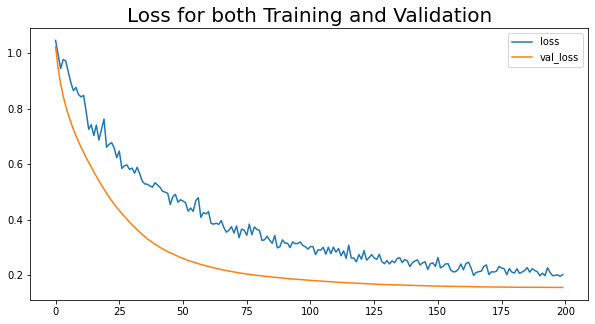

In [82]:
evaluation_metrics=pd.DataFrame(model.history.history)
evaluation_metrics.plot(figsize=(10,5))
plt.title("Loss for both Training and Validation", size = 20)

In [83]:
test_pred = model.predict(X_test)
print(roc_auc_score(y_test, test_pred))

0.9772682735645699


Text(0.5, 1.0, 'Loss for both Training and Validation')

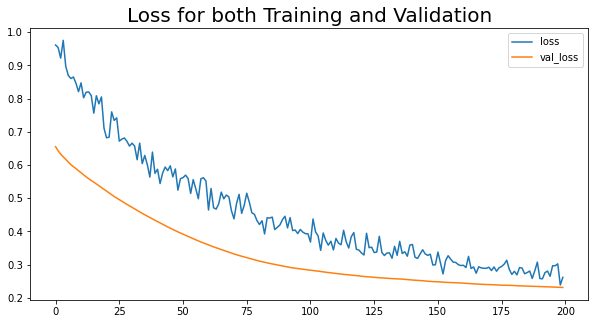

In [67]:
evaluation_metrics=pd.DataFrame(model.history.history)
evaluation_metrics.plot(figsize=(10,5))
plt.title("Loss for both Training and Validation", size = 20)

In [69]:
test_pred = model.predict(X_test)
print(roc_auc_score(y_test, test_pred))

0.9772245762711864


In [70]:
test_pred = model.predict(X_test)
print(roc_auc_score(y_test, test_pred))

0.9772245762711864


In [89]:
y_pred = model.predict_classes(X_test)

C:\Users\egadi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [90]:
cm_nn=confusion_matrix(y_test, y_pred)
cm_nn

array([[240,   3],
       [ 18, 108]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix Plotting for Neural Network model')

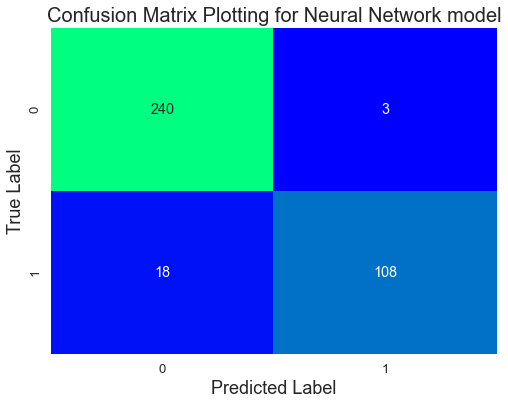

In [91]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(cm_nn, annot=True, fmt = 'g', cmap="winter", cbar = False)
plt.xlabel("Predicted Label", size = 18)
plt.ylabel("True Label", size = 18)
plt.title("Confusion Matrix Plotting for Neural Network model", size = 20)